In [2]:
# Creates projection of 3D density profile

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

file_path = "fdm-ic_p4320_b10000_m3.5e-23/density_halo_0.hdf5"

def load_data(file_path):

    with h5py.File(file_path, "r") as f:
        # Access the dataset
        dataset = f["FuzzyDM/DENSITY"]

        # Convert dataset to numpy array
        fdm_3d_density = np.array(dataset)
    
    return fdm_3d_density

fdm_3d_density = load_data(file_path)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def get_projections(fdm_3d_density):
    # Create simple 2D projections along x, y, and z axes
    x_proj = np.sum(fdm_3d_density, axis=0)
    y_proj = np.sum(fdm_3d_density, axis=1)
    z_proj = np.sum(fdm_3d_density, axis=2)
    return x_proj, y_proj, z_proj

def plot_projection(proj):
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))  # Corrected the subplot creation
    ax.imshow(proj, cmap='viridis', origin='lower', norm=LogNorm())

    # Add colorbar and labels
    cbar = fig.colorbar(ax.imshow(proj, cmap='viridis', origin='lower', norm=LogNorm()), ax=ax)
    cbar.set_label('Density')
    ax.set_title('Projection')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

    plt.show()
    
def plot_2d_projections(x_proj, y_proj, z_proj):

    f, ax = plt.subplots(1, 3, figsize=(30, 9))
    ax[0].imshow(x_proj, cmap='viridis', origin='lower', norm=LogNorm())
    ax[1].imshow(y_proj, cmap='viridis', origin='lower', norm=LogNorm())
    ax[2].imshow(z_proj, cmap='viridis', origin='lower', norm=LogNorm())

    cbar = f.colorbar(ax[0].imshow(x_proj, cmap='viridis', origin='lower', norm=LogNorm()), ax=ax[0])
    cbar.set_label('Density')
    ax[0].set_title('X-axis Projection')
    ax[0].set_xlabel('Y-axis')
    ax[0].set_ylabel('Z-axis')

    cbar = f.colorbar(ax[1].imshow(y_proj, cmap='viridis', origin='lower', norm=LogNorm()), ax=ax[1])
    cbar.set_label('Density')
    ax[1].set_title('Y-axis Projection')
    ax[1].set_xlabel('X-axis')
    ax[1].set_ylabel('Z-axis')

    cbar = f.colorbar(ax[2].imshow(z_proj, cmap='viridis', origin='lower', norm=LogNorm()), ax=ax[2])
    cbar.set_label('Density')
    ax[2].set_title('Z-axis Projection')
    ax[2].set_xlabel('Y-axis')
    ax[2].set_ylabel('Z-axis')

    plt.suptitle('2D Projections of Density (Log Scale)')
    plt.show()

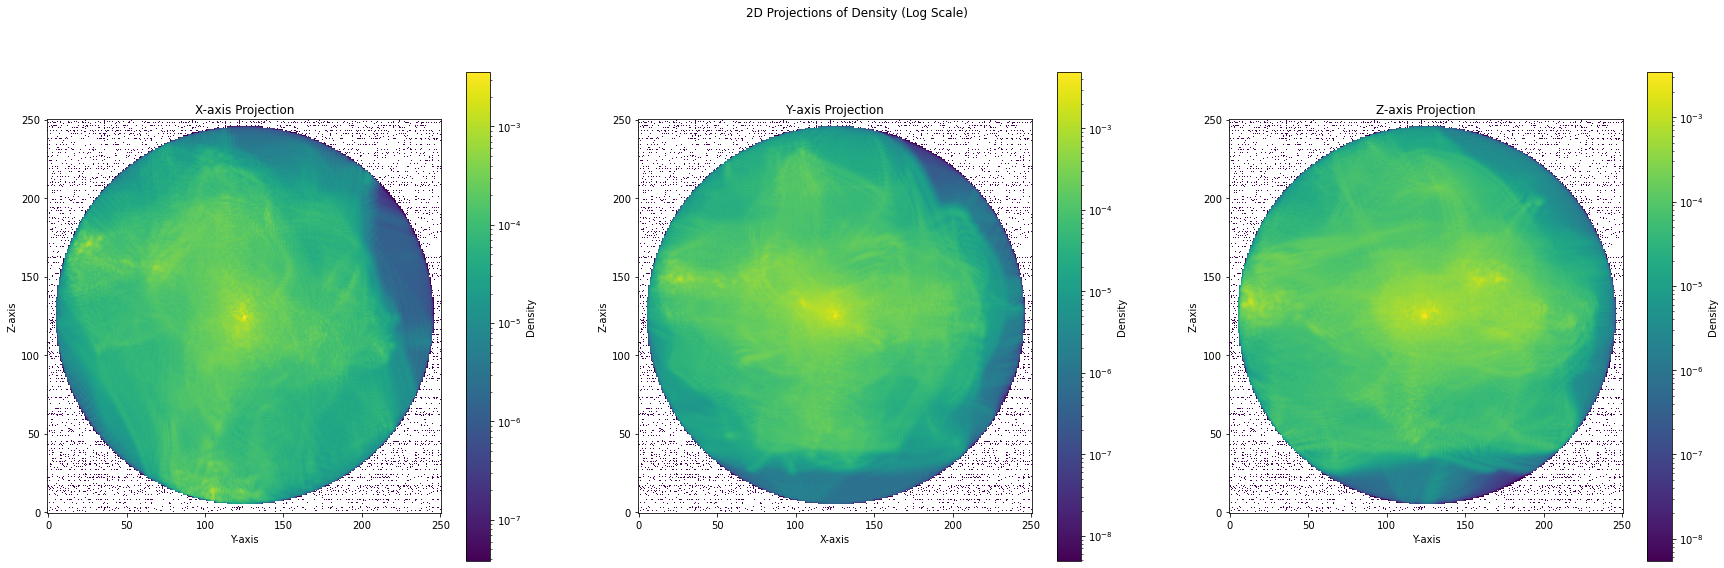

In [3]:
# Create a spherical mask so we can rotate and average density field

def make_mask(fdm_3d_density, radius):
    
    L = np.shape(fdm_3d_density)[0]
    
    for i in range(L):
        for j in range(L):
            for k in range(L):
                
                ctr = L/2
                dist_from_center = np.sqrt((i - ctr)**2 + (j - ctr)**2 + (k - ctr)**2)
                
                if dist_from_center > radius:
                    
                    # Make this Boolean instead
                    
                    fdm_3d_density[i][j][k] = 0.0
                    
    return fdm_3d_density
                
fdm_3d_density = make_mask(fdm_3d_density, 120)
x_proj, y_proj, z_proj = get_projections(fdm_3d_density)

plot_2d_projections(x_proj, y_proj, z_proj)

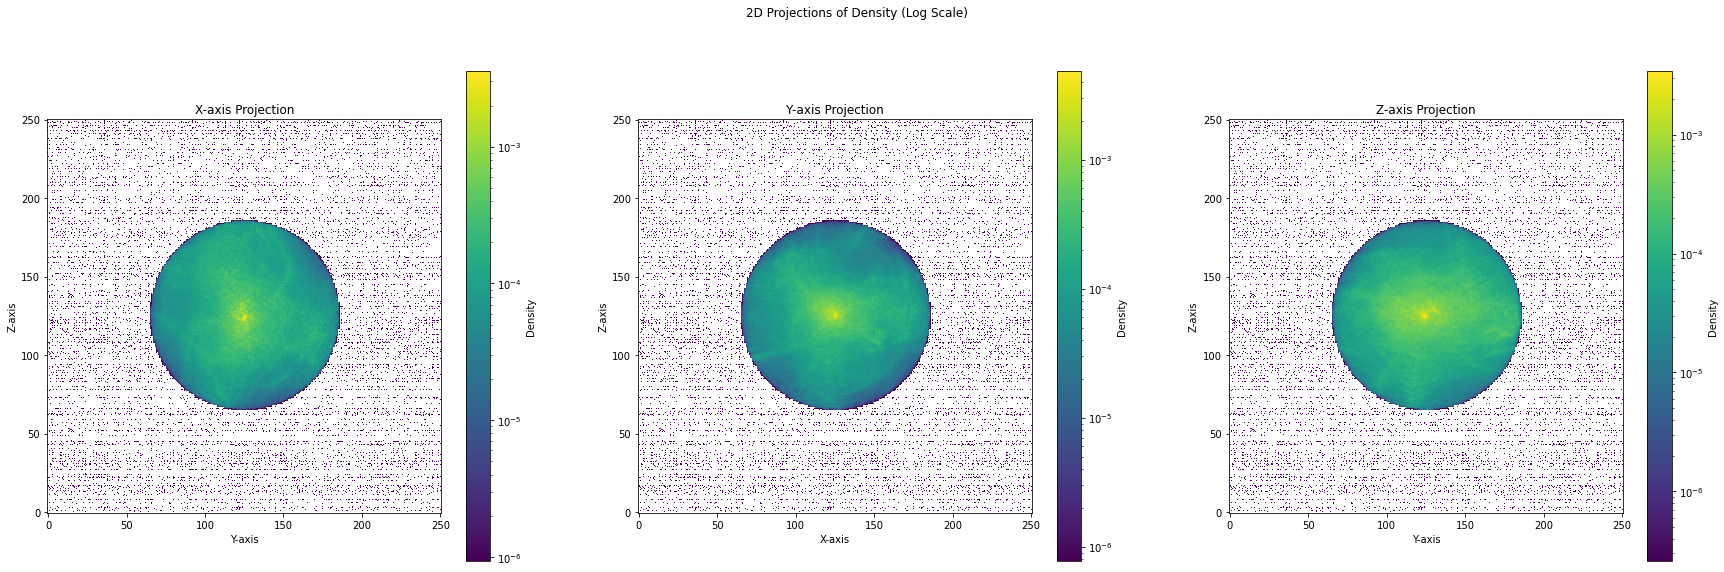

In [10]:
np.shape(fdm_3d_density)

x_proj, y_proj, z_proj = get_projections(fdm_3d_density)

plot_2d_projections(x_proj, y_proj, z_proj)

In [11]:
import numpy as np

def rotation(nx,ny,nz,theta):
    R = np.array([np.array([np.cos(theta) + (nx**2)*(1-np.cos(theta)) , nx*ny*(1-np.cos(theta)) - nz*np.sin(theta) , nx*nz*(1-np.cos(theta)) + ny*np.sin(theta)]),
                  np.array([nx*ny*(1-np.cos(theta)) + nz*np.sin(theta) , np.cos(theta) + (ny**2)*(1-np.cos(theta)) , ny*nz*(1-np.cos(theta)) - nx*np.sin(theta)]),
                  np.array([nz*nx*(1-np.cos(theta)) - ny*np.sin(theta) , nz*ny*(1-np.cos(theta)) + nx*np.sin(theta) , np.cos(theta) + (nz**2)*(1-np.cos(theta))])])
    return R

R = rotation(1, 4, 5, 0.5)
print(R)
pos = np.array([1, 1, 1])
print(np.dot(R, pos))

[[ 1.         -1.90745794  2.52978934]
 [ 2.88679745  2.83626157  1.96892322]
 [-1.30561496  2.9277743   3.93801851]]
[1.6223314  7.69198224 5.56017785]


In [9]:
def transform_3d_density(R, fdm_3d_density, mask_radius):
    
    L = np.shape(fdm_3d_density)[0]
    ctr = L/2

    transformed_density = np.zeros((L, L, L))
    
    for i in range(L):
        for j in range(L):
            for k in range(L):
                # If distance from halo is within 100 pixels, we will rotate and transform, rest is left untouched
                pos_vector = np.array([i-ctr, j-ctr, k-ctr])
                
                dist_from_center = np.sqrt(pos_vector[0]**2 + pos_vector[1]**2 + pos_vector[2]**2)
                
                if dist_from_center < mask_radius:
                    trf_pos_vector = np.dot(R, pos_vector)
                    i_tr, j_tr, k_tr = int(trf_pos_vector[0]+ctr), int(trf_pos_vector[1]+ctr), int(trf_pos_vector[2]+ctr)
                    
                    transformed_density[i][j][k] = fdm_3d_density[i_tr][j_tr][k_tr]

    return transformed_density    

#transformed_density = transform_3d_density(1, 0, 0, 0.5)

#x_proj, y_proj, z_proj = get_projections(transformed_density)
#plot_2d_projections(x_proj, y_proj, z_proj)

#transformed_density = transform_3d_density(1, 0, 0, 1)
#x_proj, y_proj, z_proj = get_projections(transformed_density)
#plot_2d_projections(x_proj, y_proj, z_proj)

Projection #: 0


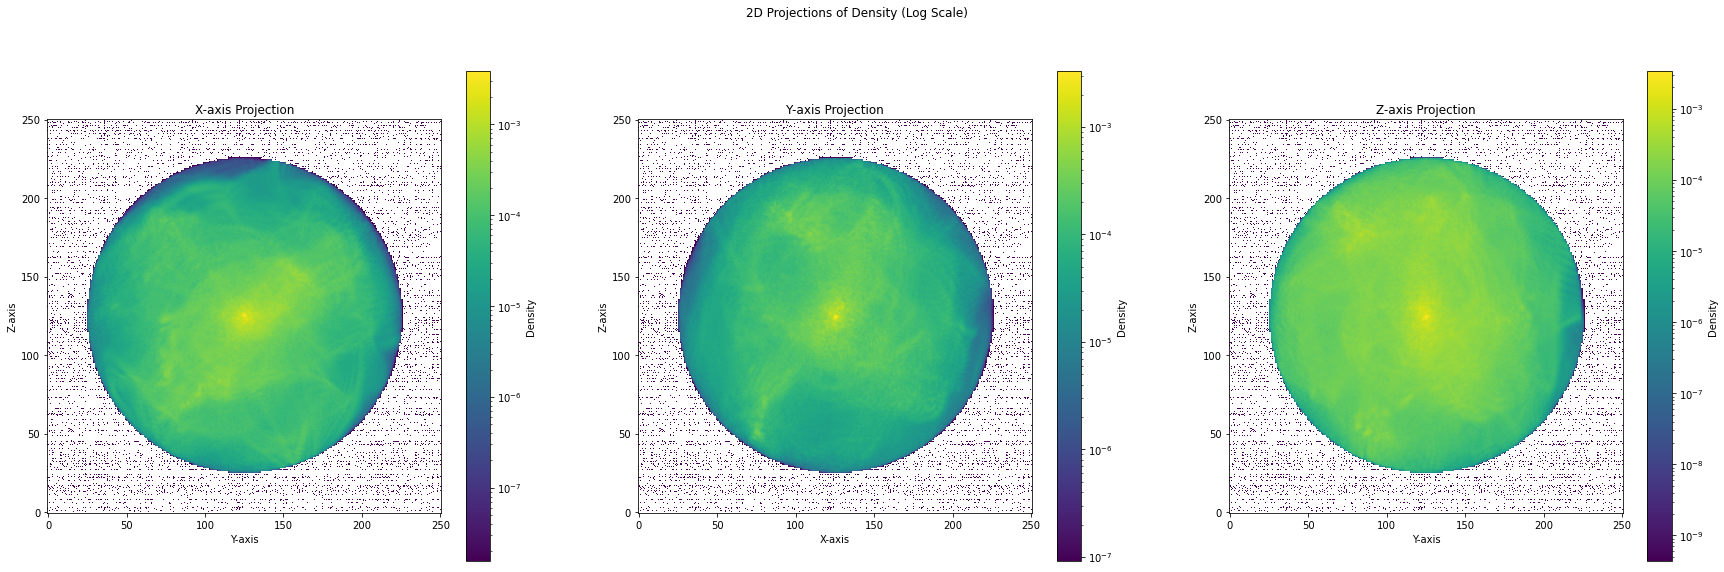

Projection #: 1


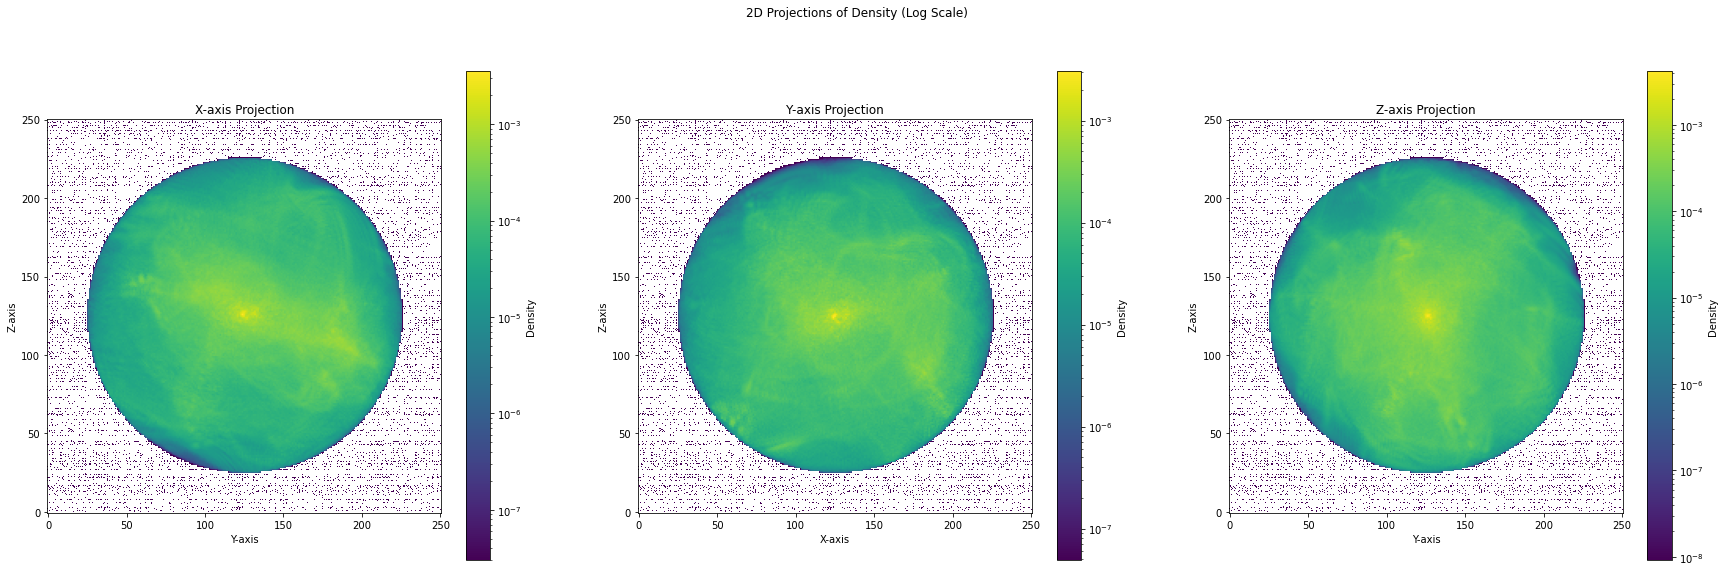

In [12]:
# Create different projections along N lines of sight
N_proj = 2
mask_radius = 100

def make_random_projections(N_proj, fdm_density, mask_radius):

    random_projs = []
    
    for i in range(N_proj):
        # Generate random vector components
        nnx = np.random.uniform(0,10)
        nny = np.random.uniform(0,10)
        nnz = np.random.uniform(0,10)
        theta = np.random.uniform(0,2*np.pi)

        # Normalize vector components to get a unit normal vector to our plane of projection
        nx = 1/np.sqrt(nnx**2 + nny**2 + nnz**2) * nnx
        ny = 1/np.sqrt(nnx**2 + nny**2 + nnz**2) * nny
        nz = 1/np.sqrt(nnx**2 + nny**2 + nnz**2) * nnz

        R = rotation(nx,ny,nz,theta)

        transformed_density = transform_3d_density(R, fdm_3d_density, mask_radius)
        #print("Projection #:", i)
        #x_proj, y_proj, z_proj = get_projections(transformed_density)
        #plot_2d_projections(x_proj, y_proj, z_proj)    
        np.save("Proj_"+str(i)+"_x.npy", x_proj)
        np.save("Proj_"+str(i)+"_y.npy", y_proj)
        np.save("Proj_"+str(i)+"_z.npy", z_proj)

        random_projs.append(transformed_density)
    
    return random_projs

